# Vežbe 2 - OCR (Optical Character Recognition)

Cilj ovih vežbi je implementacija osnovne verzije OCR-a i upoznavanje sa Keras okruženjem za rad sa neuronskim mrežama.

* Keras - Python biblioteka za laku implementaciju neuronski mreža (http://keras.io/)



### Tok aktivnosti implementacije OCR - a 

Tok aktivnosti predstavlja korake koje je potrebno izvršiti prilikom implementacije OCR-a.

<img src="images/Tok aktivnosti.png">

### Početak implementacije
Skup biblioteka sa prethodnih vežbi smo proširili Keras bibliotekom za rad sa neuronskim mrežama.

In [1]:
from __future__ import print_function
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Korak 1 - 3
Helper funkcije za rad sa slikama

In [2]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

### Korak 4 -  izdvajanje regiona od interesa

U ovom koraku potrebno je izdvojiti samo regione(konture) od interesa. Potrebno je označiti regione od interesa na slici i napraviti listu slika od regiona koja će kasnije biti ulaz za neuronsku mrežu.

### Resize
Potrebno je implementirati funkciju za promenu veličine slike na 28 x 28. Ovo se radi kako bi svi regioni koje ćemo koristiti za neuronsku mrežu bili iste veličine. *(pomoć: pogledati OpenCV funkciju resize)*

In [3]:
def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)

### Selekcija i izdvajanje regiona od interesa
* Označiti regione od interesa na originalnoj slici.
* Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
* Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
* Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni (koristiti OpenCV funkciju **rectangle**) i niz slika koje predstavljaju regione sortirane  po rastućoj vrednosti x ose

In [4]:
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_array = []
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region = image_bin[y:y+h+1,x:x+w+1]
            regions_array.append([resize_region(region), (x,y,w,h)])       
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
            
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    regions_array = sorted(regions_array, key=lambda item: item[1][0])
    sorted_regions = [region[0] for region in regions_array]
    
    return image_orig, sorted_regions

Obratite pažnju da se **koordinatni početak** u OpenCV biblioteci nalazi u **gornjem levom uglu**. Ovo može igrati bitnu ulogu kod manipulacije koordinatama.

<img src="images/slovo.jpg">

## Korak 5

Regioni od interesa su predstavljeni vektorom čiji su elementi matrice dimenzija 28x28. Elementi matrica su vrednosti 0 ili 255. Potrebno je skalirati vrednosti elemenata matrice na opseg od 0 do 1, kako bi se pogodio linearni deo sigmoid funkcije i smanjilo vreme obučavanja.
Nakon skaliranja matrice je potrebno transformisati u vektor od 784 elementa.

### Skaliranje elemenata

Skalirati sve elemente matrice sa celobrojnog opsega [0, 255] na realni opseg [0, 1].

In [5]:
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255

### Transformacija slike u vektor

Region koji je zapravo slika (matrica) dimenzija 28x28 transformiati u vektor od 784 elementa.

In [6]:
def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()

### Priprema za neuronsku mrežu

Svaki region pripremiti za ulaz na neuronsku mrežu: skaliranje elemenata na [0,1] i transformaciju u vektor.

In [7]:
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona 
        # region sa skaliranim elementima pretvoriti u vektor
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann

### Konverzija

Konvertovati alfabet u niz pogodan za obučavanje NM, odnosno niz čiji su svi elementi 0 osim elementa čiji je indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0], za drugi [0,1,0,0,0,0,0,0,0,0] itd..

In [8]:
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

## Obučavanje

### Neuronska mreža

Veštačka neuronska mreža se sastoji od 784 ulazna neurona, 128 neurona u skrivenom sloju i 10 neurona na izlazu. Zašto baš 784 neurona na ulazu i 10 neurona na izlazu? Regione smo transformisali prvo na matricu dimenzija 28x28,a zatim u vektor od 784 elementa. Što se tiče 10 neurona na izlazu, to je posledica broja znakova u alfabetu. U našem primeru alfabet (0,1,2,3,4,5,6,7,8,9) ima 10 elemenata pa nam je potrebno 10 neurona na izlazu.
Neuronska mreža je implementirana pomoću Keras biblioteke.
<img src="images/neuronska_mreza.png">

### Sigmoidalna aktivaciona funkcija
$ sigm(x) = \dfrac{1}{1 + e^{-x}} $

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/2000px-Logistic-curve.svg.png" width="300" height="300">

In [9]:
def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, epochs=10, batch_size=1, verbose = 0, shuffle=False) 
      
    return ann

## Korak 7 - određivanje pobedničkog neurona

Određivanje pobedničkog neurona. Pobednički neuron je neuron čija je aktivaciona vrednost najveća. Npr. ako imamo dva neurona sa aktivacionim vrednostima 0.3 i 0.89, pobednik je drugi sa aktivacijom 0.89.


Pronaći indeks neurona koji je najviše pobuđen.


In [10]:
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]

## Korak 8 - prikaz rezultata

Pikazati rezultat prepoznavanja neuronske mreže. Za svaki rezultat pronaći indeks pobedničkog  neurona koji ujedno predstavlja i indeks prepoznatog elementa u alfabetu. Dodati karakter iz alfabeta u result

In [11]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

## Start
Učitati sliku za obučavanje veštačke neuronske mreže. Transformisati sliku i binarni oblik i označiti regione od interesa (u ovom slučaju to su brojevi od 0 do 9).
Prikazati sliku sa označenim regionima od interesa.

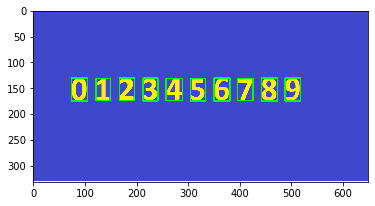

In [12]:
image_color = load_image('images/brojevi.png')
img = invert(image_bin(image_gray(image_color)))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img)
display_image(selected_regions)

In [13]:
# insert alphabet here
alphabet = [0,1,2,3,4,5,6,7,8,9]

In [14]:
inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

### Verifikacija i primer predikcije

Za verifikaciju obučenosti neuronske mreže ćemo uzeti treći i četvrti ulazni vektor (brojevi 2 i 3 iz alfabeta).
Metoda **model.predict** kao ulazni parametar prima niz vektora dimenzija 784.
Rezultat **predict** metode je niz vektora dimenzije 10, koji sadrži koeficijente pobuđenosti.

In [15]:
result = ann.predict(np.array(inputs[2:4], np.float32))
print(result)
print(display_result(result, alphabet))

[[0.01289945 0.02060736 0.96137655 0.01707854 0.00945849 0.00280576
  0.00511728 0.0207535  0.01884039 0.00734039]
 [0.00598583 0.01246118 0.0168938  0.9590204  0.01452083 0.02339712
  0.00365795 0.01485781 0.02034338 0.01745117]]
[2, 3]


## Test

Učitati sliku za testiranje rada OCR -a  'images/test.png'. Transformisati sliku u oblik pogodan za ulaz u neuronsku mrežu. 
Prikazati rezultate predikcije kao i sliku sa označenim regionima od interesa.

PSEUDO KOD:
* učitati sliku 'images/test.png'
* pretvoriti sliku u binarnu i ako je potrebno invertovati je
* ako je potrebno primeniti eroziju i/ili diletaciju
* selektovati regione od značaja
* pripremiti podatke za ulaz na NM
* pozvati metodu **predict**, a kao parametar proslediti pripremljene podatke
* prikazati rezultate predikcije


[2, 3, 5, 6, 8, 9, 1, 0]


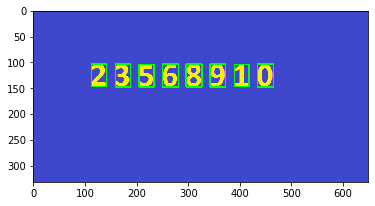

In [16]:
test_color = load_image('images/test.png')
test = invert(image_bin(image_gray(test_color)))
test_bin = erode(dilate(test))
selected_test, test_numbers = select_roi(test_color.copy(),test_bin)
display_image(selected_test)
test_inputs = prepare_for_ann(test_numbers)
result = ann.predict(np.array(test_inputs, np.float32))
print(display_result(result, alphabet))

### ZADATAK

Implementirati kalkulator. Alfabet za kalkulator je 'images/kalkulator_alfabet.png', a test primeri su 'sabiranje.png', 'oduzimanje.png' i 'slozen_izraz.png' u folderu 'images'.

In [17]:
# TODO dodatno - kalkulator
# PSEUDO KOD
# UČITATI ALFABET ZA KALKULATOR (alfabet sadrži 14 karaktera)
# PRETVORITI SLIKU U BINARNU I OZNAČITI REGIONE OD INTERESA select_roi
# UNETI NOVI ALFABET
# PRIPREMITI SELEKTOVANE REGIONE ZA OBUČAVANJE NEURONSKE MREŽE
# KONVERTOVATI NOVI ALFABET ZA OBUČAVANJE NEURONSKE MREŽE
# MODELOVATI PREŽU. NAPOMENA: PROVERITI DA LI JE BROJ IZLAZA ADEKVATNO POSTAVLJEN
# KREIRATI PREŽU create_ann
# OBUČITI MREŽU train_ann